<a href="https://colab.research.google.com/github/ernstmargo/anomaly-detection/blob/main/ONLY_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and read data

In [ ]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import ipaddress 
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
pip install memory_profiler

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/full_dataset')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,3,6,84) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_w=pd.read_csv('/content/drive/MyDrive/Dataset/Wednesday-workingHours.pcap_ISCX.csv')


#Preprocessing 





In [ ]:
def format_name(columns):
  col= []
  for x in columns:
        x=x.strip().lower().replace(' ', '_').replace('/', '_').replace('.', '_')
        col.append(x)
  return col
  
def ip_to_int(ip):
   new_ip=int(ipaddress.ip_address(ip))
   return new_ip

def rename_lables(df):
    df=df.replace({'label': {'DoS slowloris':'DOS','DoS Slowhttptest':'DOS', 'DoS Hulk':'DOS', 'DoS GoldenEye':'DOS', 'Heartbleed':'DOS', 'DDOS':'DOS'}})
    df.loc[ df['label'] !='DOS', 'label'] = 'BENIGN'
    df=df.replace({'label': {'BENIGN':0, 'DOS':1}})
    label_unique=df['label'].unique()
    k=0
    for x in label_unique:
        df=df.replace({'label': {x:k}})
        k=k+1
    return df

def preprocessing(df):
  df.columns=format_name(df.columns)
  df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['timestamp'] = df['timestamp'].values.astype('float')
  df['source_ip']=df['source_ip'].apply(ip_to_int)
  df['destination_ip']=df['destination_ip'].apply(ip_to_int)
  df=df.drop(columns=['flow_id'])
  df=rename_lables(df)
  y=df['label'].astype(int)
  x=df.drop(columns=['label'])
  return df, x, y
  


In [ ]:
df_preproc, x, y=preprocessing(df)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=42, shuffle=True)


#Scale

In [ ]:
from sklearn.preprocessing import scale
from sklearn import preprocessing


In [ ]:
x_scaled=scale(x)
x_tran_scaled=scale(x_train)
x_test_scaled=scale(x_test)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_min_max=min_max_scaler.fit_transform(x)
x_train_min_max=min_max_scaler.fit_transform(x_train)



In [ ]:
max_abs_scaler=preprocessing.MaxAbsScaler()
x_max_abs=max_abs_scaler.fit_transform(x)

#Fearture Selection

### Select best 

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [ ]:
selectkbest_chi = SelectKBest(chi2, k=20).fit(x_train_min_max, y_train)
x_min_max_selectkbest_chi = selectkbest_chi.transform(x_min_max)


In [ ]:
col_index=selectkbest_chi.get_support()

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [ ]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(x_train_min_max, y_train)
model = SelectFromModel(lsvc, prefit=True)
x_l1 = model.transform(x_min_max)
x_l1.shape

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


(2827876, 20)

In [ ]:
col_index_l1=selectkbest_chi.get_support()
x.columns[col_index_l1]

Index(['flow_duration', 'bwd_packet_length_max', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_iat_std', 'flow_iat_max',
       'fwd_iat_total', 'fwd_iat_std', 'fwd_iat_max', 'bwd_iat_std',
       'bwd_iat_max', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'fin_flag_count', 'ack_flag_count',
       'avg_bwd_segment_size', 'idle_mean', 'idle_max', 'idle_min'],
      dtype='object')

###PCA

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_min_max)


In [ ]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.shape


(3119236, 3)

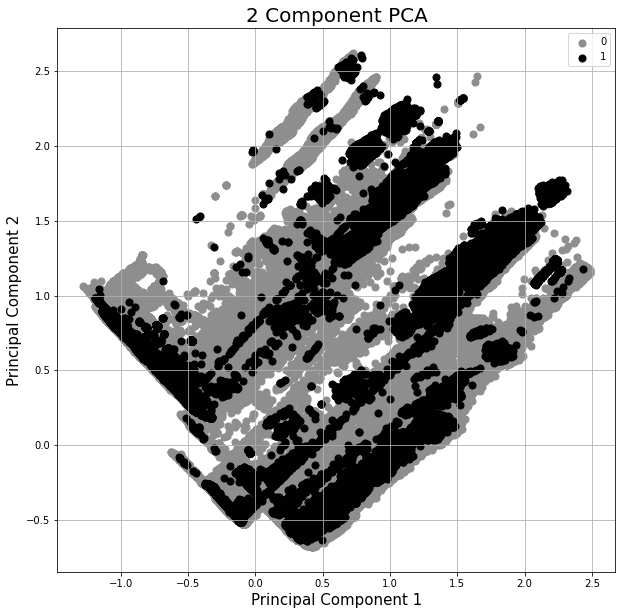

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1]
colors = ['#8e8e8e', '#010101']
markers = ["o", "o"]
for target, color, marker in zip(targets,colors,markers):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50,
               marker = marker)
ax.legend(targets)
ax.grid()
plt.savefig('6class.png')

# Two class SVM


In [ ]:
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support,precision_score, recall_score, f1_score, classification_report

In [ ]:
def class_SVM(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.95, random_state=42, shuffle=True)
    #clf = svm.SVC()
    clf=svm.LinearSVC()
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    
    print(classification_report(y_test, y_pred, digits=4))
    return y_pred, x_test, y_test

## Diffrent Feature and scale methods

In [ ]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [ ]:
%%time
%memit

y_pred_scaled_all, x_test, y_test=class_SVM(x_scaled, y)


peak memory: 23434.79 MiB, increment: -10.37 MiB


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


              precision    recall  f1-score   support

           0     0.9978    0.9961    0.9969   2447438
           1     0.9607    0.9771    0.9688    239045

    accuracy                         0.9944   2686483
   macro avg     0.9792    0.9866    0.9829   2686483
weighted avg     0.9945    0.9944    0.9944   2686483

CPU times: user 52.8 s, sys: 1.57 s, total: 54.3 s
Wall time: 53.4 s


In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(y_test, y_pred_scaled_all)
cf_matrix

array([[2437887,    9551],
       [   5477,  233568]])

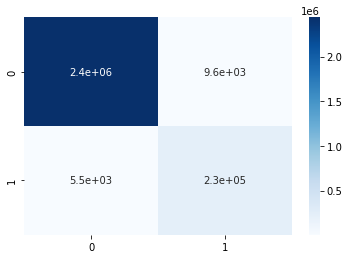

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

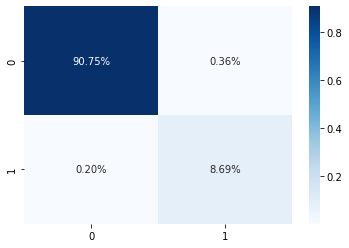

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
%%time
%memit

y_pred_min_max, x_test, y_test=class_SVM(x_min_max, y)


peak memory: 23594.30 MiB, increment: -60.00 MiB
              precision    recall  f1-score   support

           0     0.9874    0.9923    0.9899   2447438
           1     0.9169    0.8707    0.8932    239045

    accuracy                         0.9815   2686483
   macro avg     0.9522    0.9315    0.9416   2686483
weighted avg     0.9812    0.9815    0.9813   2686483

CPU times: user 23.6 s, sys: 1.41 s, total: 25 s
Wall time: 24.2 s


In [ ]:
%%time
%memit

y_pred_max_aabs, x_test, y_test=class_SVM(x_max_abs, y)


peak memory: 23596.58 MiB, increment: -46.09 MiB
              precision    recall  f1-score   support

           0     0.9806    0.9926    0.9866   2447438
           1     0.9133    0.7994    0.8525    239045

    accuracy                         0.9754   2686483
   macro avg     0.9470    0.8960    0.9196   2686483
weighted avg     0.9746    0.9754    0.9747   2686483

CPU times: user 22.4 s, sys: 1.5 s, total: 23.9 s
Wall time: 23.1 s


In [ ]:
%%time
%memit
y_pred_selectbest_20, x_test, y_test=class_SVM(x_min_max_selectkbest_chi, y)


peak memory: 23600.90 MiB, increment: 0.00 MiB
              precision    recall  f1-score   support

           0     0.9582    0.9943    0.9759   2447438
           1     0.9056    0.5557    0.6887    239045

    accuracy                         0.9553   2686483
   macro avg     0.9319    0.7750    0.8323   2686483
weighted avg     0.9535    0.9553    0.9504   2686483

CPU times: user 17.3 s, sys: 1.39 s, total: 18.7 s
Wall time: 18.4 s


In [ ]:
%%time
%memit

y_pred_pca, x_test, y_test=class_SVM(principalComponents, y)


peak memory: 23590.94 MiB, increment: -54.33 MiB
              precision    recall  f1-score   support

           0     0.9574    0.9869    0.9719   2447438
           1     0.8039    0.5501    0.6532    239045

    accuracy                         0.9480   2686483
   macro avg     0.8806    0.7685    0.8126   2686483
weighted avg     0.9437    0.9480    0.9436   2686483

CPU times: user 10.9 s, sys: 1.54 s, total: 12.4 s
Wall time: 12.1 s


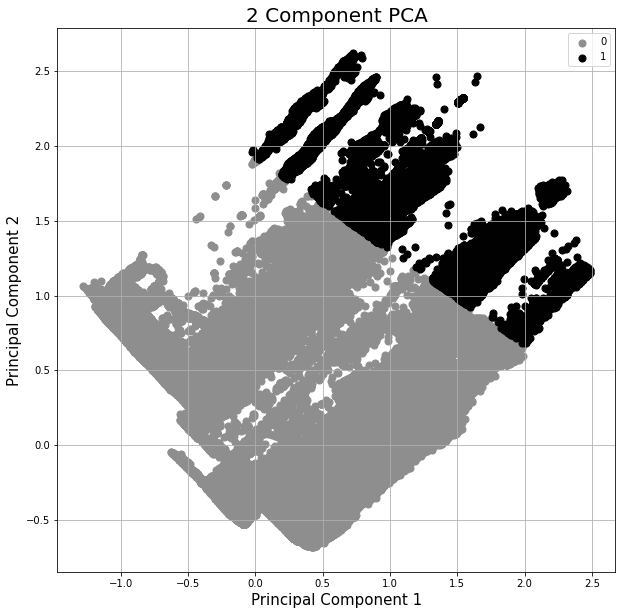

In [ ]:
principalDf = pd.DataFrame(data = x_test
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_test], axis = 1)
finalDf.shape


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1]
colors = ['#8e8e8e', '#010101']

for target, color in zip(targets,colors):
    indicesToKeep = y_pred_pca == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']              
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()

# One class SVM




In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm

In [ ]:
selectkbest_chi = SelectKBest(chi2, k=2).fit(x_train_min_max, y_train)
x_min_max_selectkbest_chi_2 = selectkbest_chi.transform(x_min_max)
x_min_max_selectkbest_chi_2.shape

NameError: ignored

In [ ]:
outliers = y[y == 1]
outliers.shape
nu=outliers.shape[0]/y.shape[0]
nu

0.08901486486677633

In [ ]:
def oneclass_SVM(x,y, nu):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=42, shuffle=False)
    clf = svm.OneClassSVM(kernel='rbf', gamma=0.00005) 
    clf.fit(x_train)
    #y_pred_train = clf.predict(x_min_max_selectkbest_chi_m)
    y_pred = clf.predict(x_test)
    y_pred=np.where(y_pred==1, 0, y_pred) 
    y_pred=np.where(y_pred==-1, 1, y_pred) 
    print(classification_report(y_pred, y_test))
    return y_pred

In [ ]:
%%time
%memit
y_pred = oneclass_SVM(x_scaled, y, nu)

peak memory: 22347.54 MiB, increment: 0.05 MiB


In [ ]:
y_pred=

In [ ]:
print(classification_report(y_pred, y_test))


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
y_pred=np.where(y_pred==-1, 1, y_pred) 
y_pred


array([1, 1, 1, ..., 1, 0, 0])

In [ ]:
print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

           0       0.49      0.77      0.60    238931
           1       0.78      0.50      0.61    383335

    accuracy                           0.60    622266
   macro avg       0.63      0.63      0.60    622266
weighted avg       0.67      0.60      0.60    622266

